# Merging the Data

### Reading in Data and Preparing to Merge

In [1]:
import pandas as pd
import pickle

OECDdf = pd.read_csv('OECD.csv')
WBdf = pd.read_csv('WB_Clean.csv')
WEOdf = pd.read_csv('weo_merged.csv', na_values='--')
WITSdf = pd.read_csv('WITS_Clean.csv')
df_lights = pickle.load(open('lights_data_prep.pkl','rb'))

# Renaming columns so that they are an exact match
WBdf.rename({'country':'Country', 'year':'Year'}, axis=1, inplace=True)
df_lights.rename({'ADMIN':'Country', 'year':'Year'}, axis=1, inplace=True)

In [2]:
# Fixing some country names in WEO data
update_dic = {'Hong Kong SAR':'Hong Kong',
              'Taiwan Province of China':'Taiwan, Province of China',
              'Czech Republic':'Czechia',
              'Democratic Republic of the Congo':'Congo, The Democratic Republic of the',
              'Islamic Republic of Iran':'Iran, Islamic Republic of',
              'Korea':'Korea, Republic of',
              'Micronesia':'Micronesia, Federated States of',
              'Moldova':'Moldova, Republic of',
              'Russia':'Russian Federation',
              'Slovak Republic':'Slovakia',
              'Tanzania':'Tanzania, United Republic of',
              'Venezuela':'Venezuela, Bolivarian Republic of',
              'Vietnam':'Viet Nam',
              'Kyrgyz Republic':'Kyrgyzstan',
              'Lao P.D.R.':"Lao People's Democratic Republic",
              'Macao SAR':'Macao',
              'Republic of Congo':'Congo',
              'São Tomé and Príncipe':'Sao Tome and Principe',
              'St. Kitts and Nevis':'Saint Kitts and Nevis',
              'St. Lucia':'Saint Lucia',
              'St. Vincent and the Grenadines':'Saint Vincent and the Grenadines',
              'Syria':'Syrian Arab Republic',
              'The Bahamas':'Bahamas',
              'The Gambia':'Gambia'}
WEOdf = WEOdf.replace({"Country": update_dic})
WEOdf.sort_values(['Country', 'Year'], inplace=True)
WEOdf.reset_index(drop=True, inplace=True)

In [3]:
# Dropping GDP and population columns from WEO data, since we have that in WB data
WEOdf.drop(['NGDP_R', 'NGDP_RPCH', 'NGDP_FY', 'LP'], axis=1, inplace=True)

# Renaming some columns to be more readable
update_dic = {'PPPEX':'PPP_Conv_Rate',
             'PPPSH':'PPP_Share_GDP',
             'TM_RPCH':'Imports_PC',
             'TX_RPCH':'Exports_PC',
             'LUR':'Unemp_Rate',
             'LE':'Employment',
             'GGXONLB_NGDP':'Govt_Revenue'}
WEOdf.rename(update_dic, axis=1, inplace=True)

### Merging the Data

In [4]:
# I'm making the executive decision to just keep the countries
# that show up in all of the datasets
merge1 = pd.merge(left=WITSdf, right=OECDdf, how='inner', on=['Country', 'Year'])
merge2 = pd.merge(left=merge1, right=WEOdf, how='inner', on=['Country', 'Year'])
merged3 = pd.merge(left=merge2, right=WBdf, how='inner', on=['Country', 'Year'])
print(len(merged3))
merged = pd.merge(left=merged3, right=df_lights, how='inner', on=['Country', 'Year'])
merged.head()

2700


,Year,Country,Max_Partners,GDP_per_unit_CO2,PPP_Conv_Rate,PPP_Share_GDP,FLIBOR6,Imports_PC,Exports_PC,Unemp_Rate,...,total_life_exp,life_expectancy_fe,life_exp_male,trade_perGDP,ISO_A3,cam,mean_light,mean_light_diff,mean_light_pct_diff,mean_light_index
0,1993,Albania,75,5.264840,19.912,0.022,NaN,0.000,0.000,22.3,...,71.860,75.039,69.037,80.518333,ALB,F101993,0.264269,NaN,NaN,100.000000
1,1994,Albania,75,5.542105,26.714,0.023,NaN,0.000,0.000,18.4,...,71.992,75.158,69.150,53.102585,ALB,F121994,0.815907,0.551638,2.087411,308.741138
2,1995,Albania,75,6.905429,28.74,0.024,NaN,0.000,0.000,12.9,...,72.205,75.352,69.347,47.610595,ALB,F121995,1.253462,0.437554,0.536279,474.312640
3,1996,Albania,75,7.477210,32.344,0.026,NaN,NaN,NaN,12.3,...,72.495,75.618,69.631,44.895427,ALB,F121996,1.456427,0.202966,0.161924,551.115338
4,1997,Albania,72,8.689693,35.371,0.022,NaN,-9.901,-19.051,14.9,...,72.838,75.931,69.982,45.425523,ALB,F141997,1.672326,0.215898,0.148238,632.811689


### Cleaning the Data

In [5]:
merged.info()
# I'm going to drop FLIBOR6 and Employment, since they are missing so many.

# I also need to fix the column that is object instead of float
# due to the comma for the numbers >= 1000.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 0 to 1868
Data columns (total 29 columns):
Year                     1869 non-null int64
Country                  1869 non-null object
Max_Partners             1869 non-null int64
GDP_per_unit_CO2         1869 non-null float64
PPP_Conv_Rate            1862 non-null object
PPP_Share_GDP            1866 non-null float64
FLIBOR6                  21 non-null float64
Imports_PC               1823 non-null float64
Exports_PC               1820 non-null float64
Unemp_Rate               1514 non-null float64
Employment               645 non-null float64
Govt_Revenue             1681 non-null float64
gdp_per_cap              1869 non-null float64
agri_perc_gdp            1869 non-null float64
agg.empl.agri.perc       1869 non-null float64
rural.pop.perc           1869 non-null float64
pop.tot                  1869 non-null float64
mobilesub_per100peeps    1869 non-null float64
intl_tourist_arrival     1869 non-null float64
total_lif

In [6]:
# Dropping FLIBOR6 and LE
cleaned_df = merged.drop(['FLIBOR6', 'Employment'], axis=1)

# Fixing object columns
cleaned_df['PPP_Conv_Rate'] = cleaned_df['PPP_Conv_Rate'].str.replace(',', '').astype(float)

cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 0 to 1868
Data columns (total 27 columns):
Year                     1869 non-null int64
Country                  1869 non-null object
Max_Partners             1869 non-null int64
GDP_per_unit_CO2         1869 non-null float64
PPP_Conv_Rate            1862 non-null float64
PPP_Share_GDP            1866 non-null float64
Imports_PC               1823 non-null float64
Exports_PC               1820 non-null float64
Unemp_Rate               1514 non-null float64
Govt_Revenue             1681 non-null float64
gdp_per_cap              1869 non-null float64
agri_perc_gdp            1869 non-null float64
agg.empl.agri.perc       1869 non-null float64
rural.pop.perc           1869 non-null float64
pop.tot                  1869 non-null float64
mobilesub_per100peeps    1869 non-null float64
intl_tourist_arrival     1869 non-null float64
total_life_exp           1869 non-null float64
life_expectancy_fe       1869 non-null float64
life_

### Imputing Data

In [7]:
# I'm going to fill in the missing data (grouped by country) by
# defining a function based on interpolate.

# This function takes one column of the dataframe and fills
# in missing values by country (unless the country is missing all of them).
def impute_func(df, col):
    # List of countries to loop through
    countries = sorted(list(set(df['Country'])))
    
    # Initializing master df to add results to
    imputed_df = pd.DataFrame(columns=['Country', 'Year', col])

    for country in countries:
        # Set up dataframe for the one country
        country_df = df.loc[df['Country']==country, ['Country','Year',col]].copy()
        
        # Convert the Year column to DateTime format and set it as index
        # (requirement for interpolate)
        country_df['Year'] = pd.to_datetime(country_df['Year'], format='%Y')
        country_df = country_df.set_index('Year')
    
        # Use interpolate on the given column with the time method
        # to fill in missing values.
        country_df[col] = country_df[col].interpolate(method='time', limit_direction='both')
        
        # Change Year back to an int column
        country_df.reset_index(inplace=True)
        country_df['Year'] = country_df['Year'].dt.year
        
        # Add specific country df to the master df
        imputed_df = pd.concat([imputed_df, country_df], axis=0)
        
    return imputed_df

In [8]:
# Now I need to use that function on all the columns of the WB df

# List of columns other than country and year
cols = list(cleaned_df.columns[2:])

# Initializing master df to add the imputed columns to
imputed_df = cleaned_df[['Country', 'Year']].copy()

# For loop imputes each column and adds it to the master df
for col in cols:
    imputed_col = impute_func(cleaned_df, col)
    imputed_df = pd.merge(left=imputed_df, right=imputed_col, how='right',
                  on=['Country', 'Year'])


imputed_df.info()
# All columns are good except Unemp_Rate and Govt_Revenue

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 0 to 1868
Data columns (total 27 columns):
Country                  1869 non-null object
Year                     1869 non-null object
Max_Partners             1869 non-null object
GDP_per_unit_CO2         1869 non-null float64
PPP_Conv_Rate            1869 non-null float64
PPP_Share_GDP            1869 non-null float64
Imports_PC               1869 non-null float64
Exports_PC               1869 non-null float64
Unemp_Rate               1575 non-null float64
Govt_Revenue             1848 non-null float64
gdp_per_cap              1869 non-null float64
agri_perc_gdp            1869 non-null float64
agg.empl.agri.perc       1869 non-null float64
rural.pop.perc           1869 non-null float64
pop.tot                  1869 non-null float64
mobilesub_per100peeps    1869 non-null float64
intl_tourist_arrival     1869 non-null float64
total_life_exp           1869 non-null float64
life_expectancy_fe       1869 non-null float64
lif

In [9]:
# Let's see what countries are missing from Unemp_Rate
UR = imputed_df.loc[:,['Country', 'Year', 'Unemp_Rate']].copy()
UR = UR.dropna()
UR_countries = set(UR['Country'])
all_countries = set(imputed_df['Country'])
all_countries - UR_countries
# This column is missing significant countries, so
# I am going to drop it

{'Bangladesh',
 'Benin',
 'Cameroon',
 'Ethiopia',
 'Ghana',
 'Guatemala',
 'India',
 'Lebanon',
 'Mozambique',
 'Oman',
 'Senegal',
 'Togo',
 'United Arab Emirates',
 'Zambia'}

In [10]:
imputed_df.drop('Unemp_Rate', axis=1, inplace=True)

In [11]:
# Let's see what countries are missing from Govt_Revenue
GR = imputed_df.loc[:,['Country', 'Year', 'Govt_Revenue']].copy()
GR = GR.dropna()
GR_countries = set(GR['Country'])
all_countries = set(imputed_df['Country'])
all_countries - GR_countries
# This is only missing one country, so I will remove Singapore
# (although, Govt_Revenue may not be useful--in that case
# we should just remove this column and leave Singapore in)

{'Singapore'}

In [12]:
# Removing Singapore
imputed_df.dropna(inplace=True)
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1848 entries, 0 to 1868
Data columns (total 26 columns):
Country                  1848 non-null object
Year                     1848 non-null object
Max_Partners             1848 non-null object
GDP_per_unit_CO2         1848 non-null float64
PPP_Conv_Rate            1848 non-null float64
PPP_Share_GDP            1848 non-null float64
Imports_PC               1848 non-null float64
Exports_PC               1848 non-null float64
Govt_Revenue             1848 non-null float64
gdp_per_cap              1848 non-null float64
agri_perc_gdp            1848 non-null float64
agg.empl.agri.perc       1848 non-null float64
rural.pop.perc           1848 non-null float64
pop.tot                  1848 non-null float64
mobilesub_per100peeps    1848 non-null float64
intl_tourist_arrival     1848 non-null float64
total_life_exp           1848 non-null float64
life_expectancy_fe       1848 non-null float64
life_exp_male            1848 non-null float64
tra

In [13]:
# We have the years 1990-2016 and the following countries
# available for analysis
sorted(list(set(imputed_df['Country'])))

['Albania',
 'Algeria',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bangladesh',
 'Belarus',
 'Belgium',
 'Benin',
 'Brazil',
 'Bulgaria',
 'Cameroon',
 'Canada',
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Croatia',
 'Cyprus',
 'Denmark',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Estonia',
 'Ethiopia',
 'Finland',
 'France',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Guatemala',
 'Honduras',
 'Hungary',
 'Iceland',
 'India',
 'Indonesia',
 'Ireland',
 'Israel',
 'Italy',
 'Jamaica',
 'Japan',
 'Jordan',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lebanon',
 'Lithuania',
 'Luxembourg',
 'Malaysia',
 'Malta',
 'Mauritius',
 'Mexico',
 'Morocco',
 'Mozambique',
 'Netherlands',
 'New Zealand',
 'Nicaragua',
 'Nigeria',
 'Norway',
 'Oman',
 'Panama',
 'Paraguay',
 'Peru',
 'Philippines',
 'Poland',
 'Portugal',
 'Romania',
 'Saudi Arabia',
 'Senegal',
 'Slovakia',
 'Slovenia',
 'South Africa',
 'Spain',
 'Sri Lanka',
 'Sweden',
 'Switzerland',
 'Thailand',
 

### Writing to CSV

In [71]:
imputed_df.to_csv('merged.csv', index=False)
imputed_df.to_pickle('merged_data.pkl')


In [14]:
imputed_df

,Country,Year,Max_Partners,GDP_per_unit_CO2,PPP_Conv_Rate,PPP_Share_GDP,Imports_PC,Exports_PC,Govt_Revenue,gdp_per_cap,...,total_life_exp,life_expectancy_fe,life_exp_male,trade_perGDP,ISO_A3,cam,mean_light,mean_light_diff,mean_light_pct_diff,mean_light_index
0,Albania,1993,75,5.264840,19.912,0.022,0.000000,0.000000,-6.424,1370.830016,...,71.860,75.039,69.037,80.518333,ALB,F101993,0.264269,0.551638,2.087411,100.000000
1,Albania,1994,75,5.542105,26.714,0.023,0.000000,0.000000,-6.424,1493.790201,...,71.992,75.158,69.150,53.102585,ALB,F121994,0.815907,0.551638,2.087411,308.741138
2,Albania,1995,75,6.905429,28.740,0.024,0.000000,0.000000,-6.424,1703.286747,...,72.205,75.352,69.347,47.610595,ALB,F121995,1.253462,0.437554,0.536279,474.312640
3,Albania,1996,75,7.477210,32.344,0.026,-4.943728,-9.512469,-6.424,1869.871255,...,72.495,75.618,69.631,44.895427,ALB,F121996,1.456427,0.202966,0.161924,551.115338
4,Albania,1997,72,8.689693,35.371,0.022,-9.901000,-19.051000,-6.424,1676.131932,...,72.838,75.931,69.982,45.425523,ALB,F141997,1.672326,0.215898,0.148238,632.811689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,Zambia,2009,137,25.644160,1.940,0.047,-14.334000,19.198000,-0.722,1390.331446,...,54.130,56.265,51.972,56.121381,ZMB,F162009,0.112410,-0.007636,-0.063613,130.503472
1865,Zambia,2010,140,27.179230,2.185,0.050,32.764000,20.145000,-1.023,1489.459070,...,55.655,57.786,53.478,67.900930,ZMB,F182010,0.117686,0.005276,0.046938,136.629064
1866,Zambia,2011,139,23.685540,2.378,0.050,26.938000,1.793000,-0.834,1525.562575,...,57.126,59.278,54.911,76.212834,ZMB,F182011,0.185468,0.067782,0.575953,215.321039
1867,Zambia,2012,163,18.593390,2.497,0.053,23.883000,27.935000,-1.509,1591.319994,...,58.502,60.708,56.220,79.099742,ZMB,F182012,0.159428,-0.026040,-0.140401,185.089644


In [29]:
imputed_df.columns

Index(['Country', 'Year', 'Max_Partners', 'GDP_per_unit_CO2', 'PPP_Conv_Rate',
       'PPP_Share_GDP', 'Imports_PC', 'Exports_PC', 'Govt_Revenue',
       'gdp_per_cap', 'agri_perc_gdp', 'agg.empl.agri.perc', 'rural.pop.perc',
       'pop.tot', 'mobilesub_per100peeps', 'intl_tourist_arrival',
       'total_life_exp', 'life_expectancy_fe', 'life_exp_male', 'trade_perGDP',
       'ISO_A3', 'cam', 'mean_light', 'mean_light_diff', 'mean_light_pct_diff',
       'mean_light_index'],
      dtype='object')

In [27]:
imputed_df.gdp_per_cap.describe()

count      1848.000000
mean      16456.696649
std       20067.016056
min         178.801690
25%        2560.936089
50%        7030.422492
75%       26933.895796
max      111968.349501
Name: gdp_per_cap, dtype: float64

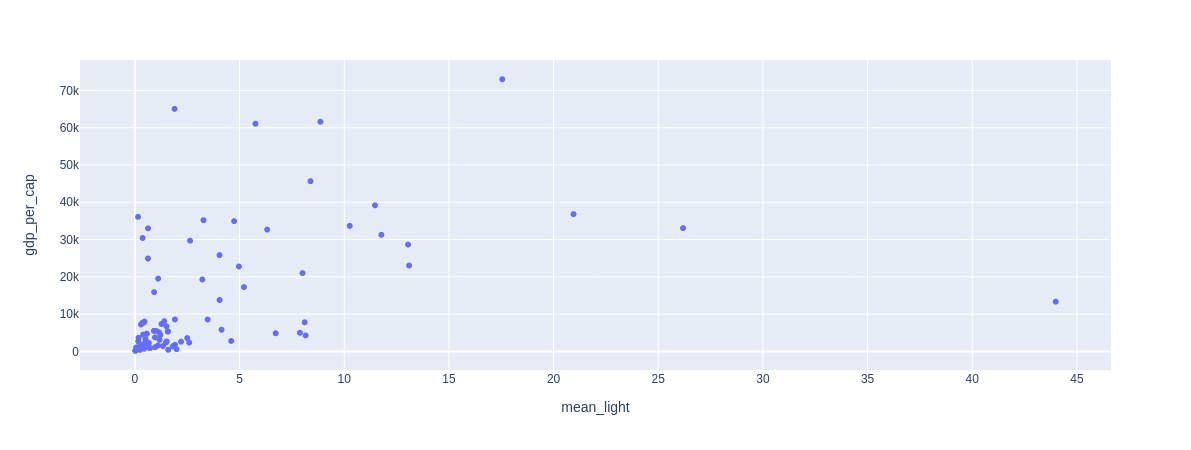

In [23]:
import plotly.express as px
fig = px.scatter(imputed_df[imputed_df['Year'] == 1993], x = 'mean_light', y = 'gdp_per_cap', animation_group="Country")

fig.show()

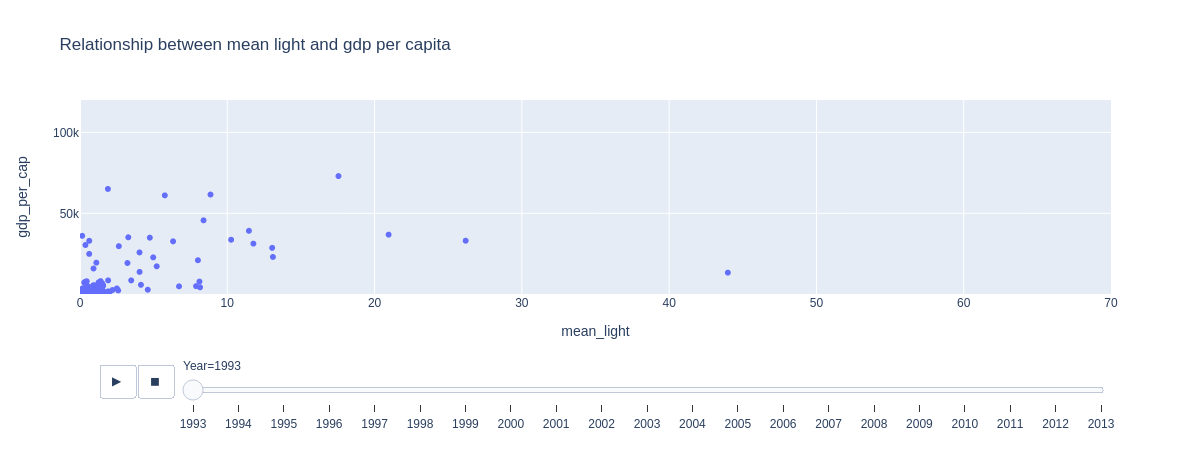

In [37]:
fig = px.scatter(imputed_df, x="mean_light", y="gdp_per_cap", animation_frame="Year", animation_group="Country",hover_name="Country",
           range_x=[0,70], range_y=[150,120000], title='Relationship between mean light and gdp per capita')
fig.show()

In [38]:
plotly.offline.plot(fig, filename='light_gdp.html')

'light_gdp.html'

In [ ]:
pipeline = Pipeline(stages = [vecAssembler,
                   rf,
                   labelConverter])

In [ ]:
model_rf = pipeline.fit(df_train)